In [151]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")

In [152]:
#from langchain_groq import ChatGroq
#llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")

In [153]:
llm.invoke("Hello, My name is ratn, how are you?")

AIMessage(content="Hello Ratn, I'm just a virtual assistant, but I'm here and ready to help you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 19, 'total_tokens': 45, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BnIT0yoEptdvBIFwaFxIEcWq58ytf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--5e916766-bda1-495a-86ff-d9b21394d61f-0', usage_metadata={'input_tokens': 19, 'output_tokens': 26, 'total_tokens': 45, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [154]:
from langchain_community.tools.tavily_search import TavilySearchResults
search_tool = TavilySearchResults(k=3)

In [155]:
search_tool.invoke("What is top 5 news in india today ?")

[{'title': 'Top 5 News Headlines in India | 25 June 2025 - Dailymotion',
  'url': 'https://www.dailymotion.com/video/x9lvops',
  'content': "Stay updated with today's biggest headlines from across India! In this video, we bring you the top 5 trending and most important news stories for June 25, 2025.",
  'score': 0.69746524},
 {'title': 'India Today - Latest News, Breaking News Today - Entertainment, Cricket ...',
  'url': 'https://www.indiatoday.in/',
  'content': 'Check out the latest news from India and around the world. Latest India news on Bollywood, Politics, Business, Cricket, Technology and Travel.',
  'score': 0.6538572},
 {'title': 'India News | Latest India News Headlines Today and ... - Times of India',
  'url': 'https://m.timesofindia.com/india',
  'content': 'India News Today: Get latest India news and breaking news from India on Times of India. TOI brings the top news headlines from India on Politics, Elections, Current Affairs and more',
  'score': 0.6122407},
 {'title'

In [156]:
code = """
x=10
y=x+10
print(y)
"""

In [157]:
from langchain_experimental.utilities import PythonREPL
repl=PythonREPL()

In [158]:
repl.run(code)

'20\n'

In [159]:
from typing import Annotated
from langchain.tools import tool
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [160]:
python_repl_tool.invoke(code)

'Successfully executed:\n\\`\\`\\`python\n\nx=10\ny=x+10\nprint(y)\n\n\\`\\`\\`\nStdout: 20\n\n\nIf you have completed all tasks, respond with FINAL ANSWER.'

In [161]:
members=["researcher","coder"]
options = members+["FINSIH"]
options

['researcher', 'coder', 'FINSIH']

In [162]:
from typing import Literal, TypedDict
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINSIH']

In [163]:
from langgraph.graph import MessagesState,StateGraph,END,START
class State(MessagesState):
    next:str

In [164]:
system_prompt = f"""
You are a supervisor managing a task delegation system with the following workers: {members}.

Your job is to decide which worker should act next based on the user's input.

Guidelines:
- Carefully read the user’s message.
- If the message clearly requires a specific action (e.g., search, compute, rewrite), assign it to the appropriate worker.
- If the message is general, conversational, or does **not** require any specific action, immediately respond with `FINISH`.
- Do **not** invent tasks or assign actions unless the message clearly demands it.

Each worker will return results after completing their task.
Once all necessary tasks are completed, end the flow by responding with `FINISH`.

Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.
"""

In [165]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [166]:
print(system_prompt)

"
You are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.



In [167]:
from langgraph.types import Command
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
        
    return Command(goto=goto, update={"next":goto})

In [168]:
from langgraph.types import Command
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [169]:
from langgraph.types import Command
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [170]:
a2a_graph = StateGraph(State)

a2a_graph.add_node("supervisor",supervisor_agent)
a2a_graph.add_node("researcher",research_agent)
a2a_graph.add_node("coder",coder_agent)

a2a_graph.set_entry_point("supervisor")
##a2a_graph.add_edge("supervisor","researcher")
##a2a_graph.add_edge("supervisor","coder")

a2a_app=a2a_graph.compile()


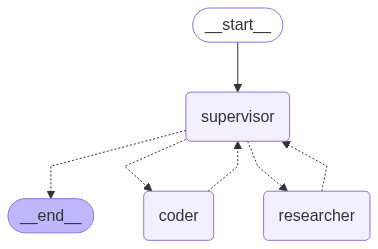

In [171]:
from IPython.display import Image, display
display(Image(a2a_app.get_graph(xray=True).draw_mermaid_png()))

In [172]:
for s in a2a_app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************
(('coder:5c16e412-b1a2-0aae-6c96-19b034a01dd7',), {'agent': {'messages': [AIMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 104, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BnIT7YclglPlfnAs2nTsS6BkAo9NG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--92311571-d5d0-49df-948e-97a18c84b43a-0', usage_metadata={'input_tokens': 104, 'output_tokens': 15, 'total_tokens': 119, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outp

**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
(('researcher:cb307705-daf7-8cc2-c27f-2a98fcde6de3',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ki5GfTXG7IPmhH5xsqgrGule', 'function': {'arguments': '{"query": "USA GDP 2019"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_GWJkMWPtY2N4VBGuNJ4Hb7pu', 'function': {'arguments': '{"query": "USA GDP 2020"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_ITILtkMrljVDqgvJz1kPBaOg', 'function': {'arguments': '{"query": "USA GDP 2021"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_nqa4XxVWyIlDtPUK3Orjvh3g', 'function': {'arguments': '{"query": "USA GDP 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_fWtRdbujf9AHztUJvLegAk8M', 'function': {'arguments': '{"query": "USA GDP 2023"}', 'name': '

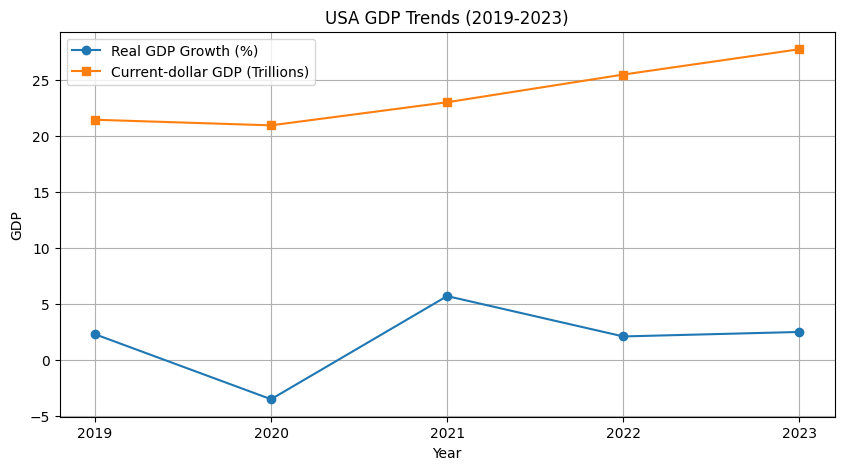

(('coder:be7edefd-1a7b-0250-15c4-32527e274195',), {'tools': {'messages': [ToolMessage(content="Successfully executed:\n\\`\\`\\`python\nimport matplotlib.pyplot as plt\n\n# Data for the plot\nyears = [2019, 2020, 2021, 2022, 2023]\nreal_gdp_growth = [2.3, -3.5, 5.7, 2.1, 2.5]\ncurrent_dollar_gdp = [21.43, 20.93, 22.99, 25.46, 27.72]\n\n# Plotting the graph\nplt.figure(figsize=(10, 5))\nplt.plot(years, real_gdp_growth, marker='o', label='Real GDP Growth (%)')\nplt.plot(years, current_dollar_gdp, marker='s', label='Current-dollar GDP (Trillions)')\n\n# Adding title and labels\nplt.title('USA GDP Trends (2019-2023)')\nplt.xlabel('Year')\nplt.ylabel('GDP')\nplt.xticks(years)\nplt.grid(True)\nplt.legend()\n\n# Display the plot\nplt.show()\n\\`\\`\\`\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl_tool', id='66094eb6-c219-417f-9716-9e7e89dc71bf', tool_call_id='call_x2Gv8EGW1zhHmGbYxX2kszzG')]}})
**********BELOW IS MY STATE***************
(('coder:

In [173]:
for s in a2a_app.stream({"messages": [("user", "Tell me the USA GDP trends from last 5 year and Plot the line graph")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

In [175]:
a2a_app.invoke({"messages": [("user","what is an efficient python code to get the prime number ? Provide the code snippet")]},subgraphs=True)

**********BELOW IS MY GOTO***************
coder
**********BELOW IS MY GOTO***************
FINISH


((),
 {'messages': [HumanMessage(content='what is an efficient python code to get the prime number ? Provide the code snippet', additional_kwargs={}, response_metadata={}, id='fb4b0c8e-d402-4b80-8a74-3223af7eeb71'),
   HumanMessage(content="Here's an efficient Python code snippet to find prime numbers using the Sieve of Eratosthenes algorithm:\n\n```python\ndef sieve_of_eratosthenes(limit):\n    prime = [True] * (limit + 1)\n    p = 2\n    while (p * p <= limit):\n        if (prime[p] == True):\n            for i in range(p * p, limit + 1, p):\n                prime[i] = False\n        p += 1\n    prime_numbers = [p for p in range(2, limit + 1) if prime[p]]\n    return prime_numbers\n\nlimit = 100\nprint(sieve_of_eratosthenes(limit))\n```\n\nThis code efficiently finds all prime numbers up to a specified limit using the Sieve of Eratosthenes method. Adjust the `limit` variable to find primes up to a different number.", additional_kwargs={}, response_metadata={}, name='coder', id='c9b96